In [1]:
!pip install ete3
!pip install pyvolve
!pip install pyqt5


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from ete3 import Tree
import pyvolve

# Random tree with 100 leaves
tree = Tree()
tree.populate(100)
print(tree)


            /-aaaaaaaaaq
         /-|
        |  |   /-aaaaaaaaar
        |   \-|
        |      \-aaaaaaaaas
      /-|
     |  |      /-aaaaaaaaat
     |  |   /-|
     |  |  |   \-aaaaaaaaau
     |   \-|
     |     |   /-aaaaaaaaav
     |      \-|
   /-|         \-aaaaaaaaaw
  |  |
  |  |      /-aaaaaaaaax
  |  |   /-|
  |  |  |  |   /-aaaaaaaaay
  |  |  |   \-|
  |  |  |      \-aaaaaaaaaz
  |   \-|
  |     |      /-aaaaaaaabb
  |     |   /-|
  |     |  |  |   /-aaaaaaaabc
  |     |  |   \-|
  |      \-|      \-aaaaaaaabd
  |        |
  |        |   /-aaaaaaaabe
  |         \-|
  |           |   /-aaaaaaaabf
  |            \-|
  |              |   /-aaaaaaaabg
  |               \-|
  |                 |   /-aaaaaaaabh
  |                  \-|
  |                     \-aaaaaaaabi
  |
  |            /-aaaaaaaabj
  |         /-|
  |        |  |   /-aaaaaaaabk
  |        |   \-|
  |        |     |   /-aaaaaaaabl
  |        |      \-|
  |      /-|         \-aaaaaaaabm
  |     |  |
  |    

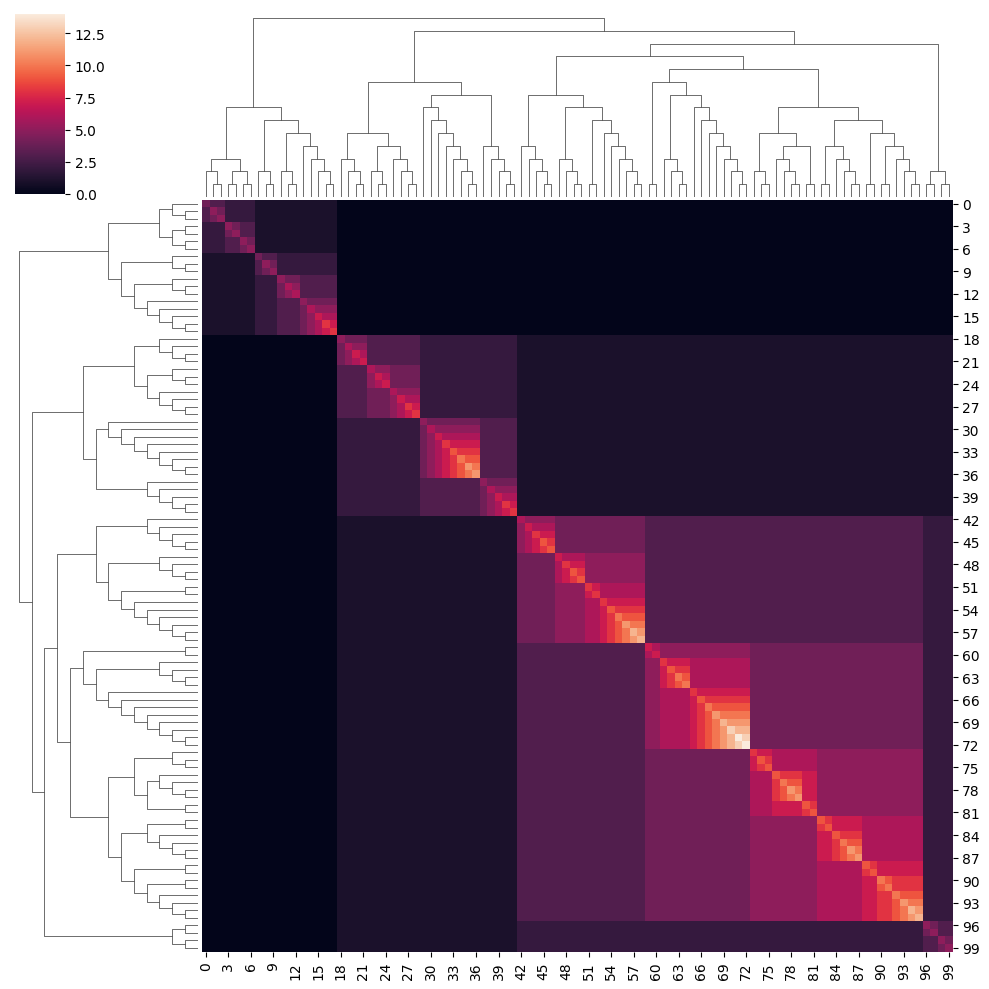

In [3]:
# Given a tree, generate covariance matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def tree_to_cov(tree):
    cov = np.zeros((len(tree), len(tree)))
    leaves = tree.get_leaves()
    for i, leaf_i in enumerate(leaves):
        for j, leaf_j in enumerate(leaves):
            if i == j:
                cov[i, j] = leaf_i.get_distance(tree)
            else:
                common_ancestor = tree.get_common_ancestor(leaf_i, leaf_j)
                cov[i, j] = common_ancestor.get_distance(tree)
    return cov

cov = tree_to_cov(tree)

# Plot
def tree_to_linkage(tree):
    leaves = tree.get_leaves()
    n_leaves = len(leaves)
    leaf_dict = {leaf: i for i, leaf in enumerate(leaves)}
    linkage = []
    node_heights = {}

    def traverse(node):
        if node.is_leaf():
            node_heights[node] = 0
            return leaf_dict[node]
        
        left, right = node.children
        left_idx = traverse(left)
        right_idx = traverse(right)
        
        new_idx = len(leaf_dict) + len(linkage)
        
        # Calculate the height of this node
        height = max(node_heights[left], node_heights[right]) + node.dist
        node_heights[node] = height
        
        linkage.append([left_idx, right_idx, height, len(node)])
        
        return new_idx

    traverse(tree)
    return np.array(linkage)

linkage = tree_to_linkage(tree)
sns.clustermap(cov, row_linkage=linkage, col_linkage=linkage)
# plt.matshow(cov)
# plt.colorbar()
# plt.show()

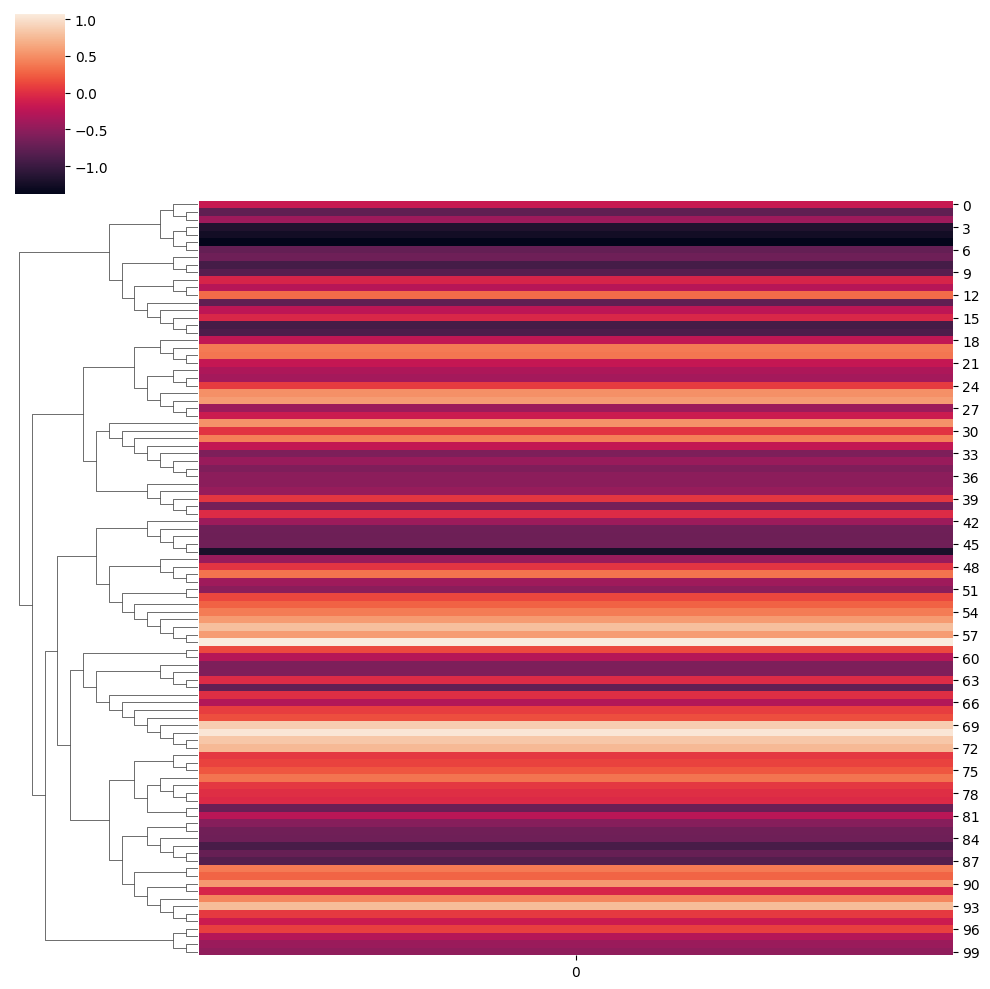

In [13]:
# Simulate a numerical quantity from this

def simulate_scalar(cov, lam=1., mean=0., n_scalars=1, scale=1.):
    n = len(cov)
    cov1 = cov / cov.max() * scale # Normalize like this
    cov2 = np.eye(n) * scale
    cov3 = lam * cov1 + (1 - lam) * cov2
    mu = np.zeros(n) * mean
    return np.random.multivariate_normal(mu, cov3, n_scalars).reshape(n, n_scalars)

scalar = simulate_scalar(cov)
sns.clustermap(scalar, row_linkage=linkage, col_cluster=False)

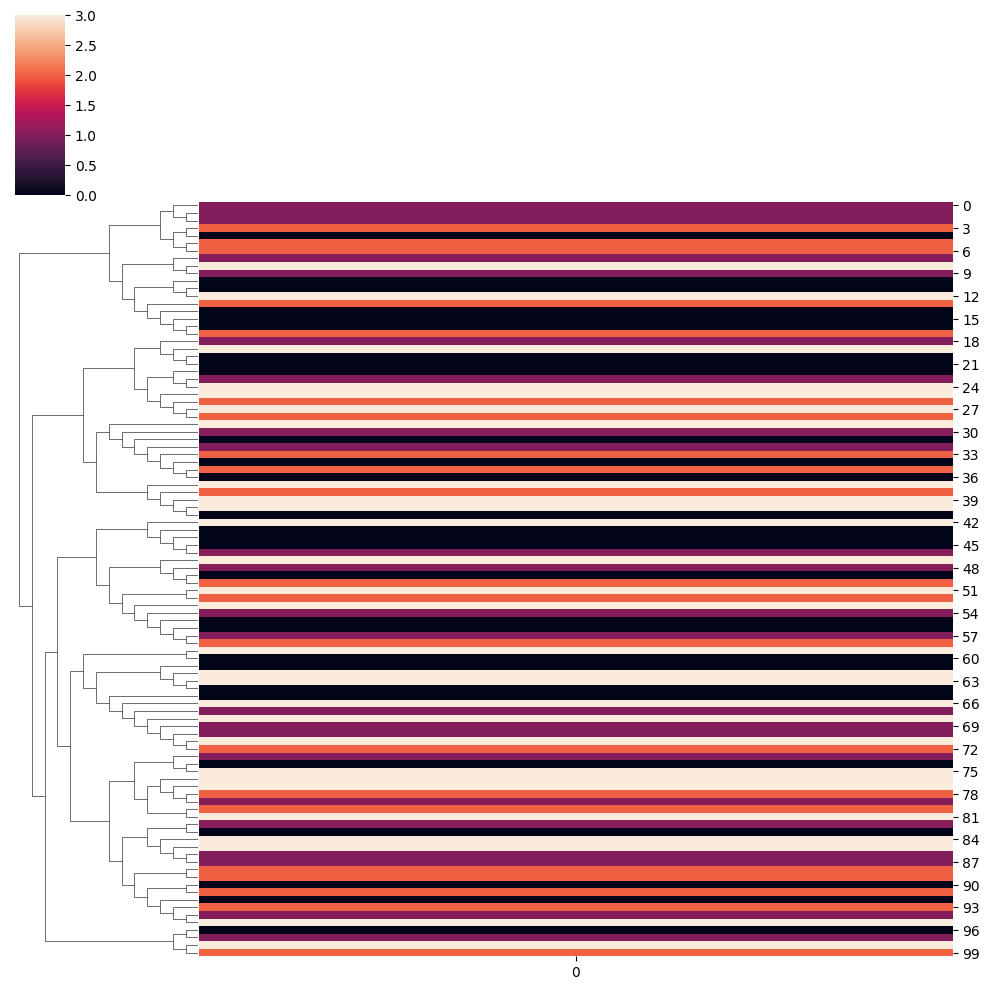

In [22]:
def simulate_binary(**kwargs):
    probs = simulate_scalar(**kwargs)
    # Rescale to [0, 1]
    # probs = 1. / (1 + np.exp(-probs)) # Sigmoid
    # Softmax
    probs = np.exp(probs) / np.exp(probs).sum(axis=1, keepdims=True)

    out = []
    for prob in probs:
        out.append(np.random.multinomial(1, prob))
    return np.argmax(np.array(out), axis=1).reshape(len(probs), 1)

np.random.seed(42)
binary = simulate_binary(cov=cov, n_scalars=4, scale=10000.)
sns.clustermap(binary, row_linkage=linkage, col_cluster=False)

# Pyvolve stuff

This code generates a random phylogenetic tree (using `ete3.Tree.populate`) and then generates 100 BP of nucleotide sequences from it.

Some things to know about Pyvolve:
* Pyvolve does NOT simulate insertions or deletions. This means that distances reduce to Hamming distances, and we don't need to use Levenshtein distances.
* Evolutionary models are defined with the `pyvolve.Model` class.
    * The `model_type` parameter tells you how to pick mutations. Options include `nucleotide` (basic nucleotide model), various empirical amino-acid models, empirical codon models, etc. In the absence of a good reason to prefer a more sophisticated model, we're going to stick with `nucleotide` here.
    * `nucleotide` assumes that equilibirium frequencies and mutation rates are all equal
* Partitions are defined with the `pyvolve.Partition` class, and require a model.
    * Also need to specify the `size` parameter (number of nucleotides in sequence)
    * It's not really clear what a ``partition'' is, to me, but apparently this abstraction is conventional in the evolutionary simulator literature
* Evolvers are defined with the `pyvolve.Evolver` class, and require a partition.
    * Needs to get called, e.g. `evolver = pyvolve.Evolver(...); evolver()`
    * Can evolve an iterable of partitions, if for some reason that's something you want. This is probably not useful for our purposes.
    * Outputs three files to the working directory:
        * `simulated_alignment.fasta`: a FASTA of the simulated sequences
        * `site_rates.txt`: a tab-delimited file cataloguing partitions and rate categories (probably safe to ignore, for us)
        * `site_rates_info.txt`: a tab-delimited file cataloguing rate factors and probabilities associated with each rate category (also safe to ignore)

In [6]:
# Generate sequences using Pyvolve

# Convert to Newick for Pyvolve
newick_tree = tree.write(format=1)

# Create a Pyvolve tree and rescale it to match our desired mutation rate
pyvolve_tree = pyvolve.read_tree(tree=newick_tree, scale_tree=.01)

# Create a Pyvolve model and partition
pyvolve_model = pyvolve.Model("nucleotide", params)
pyvolve_partition = pyvolve.Partition(models=pyvolve_model, size=1000)

# Run the evolutionary simulation
pyvolve_evolver = pyvolve.Evolver(tree=pyvolve_tree, partitions=pyvolve_partition)
pyvolve_evolver()

# Print the resulting sequences
seqs = pyvolve_evolver.get_sequences()
for name, seq in seqs.items():
    print(name, seq)

NameError: name 'params' is not defined

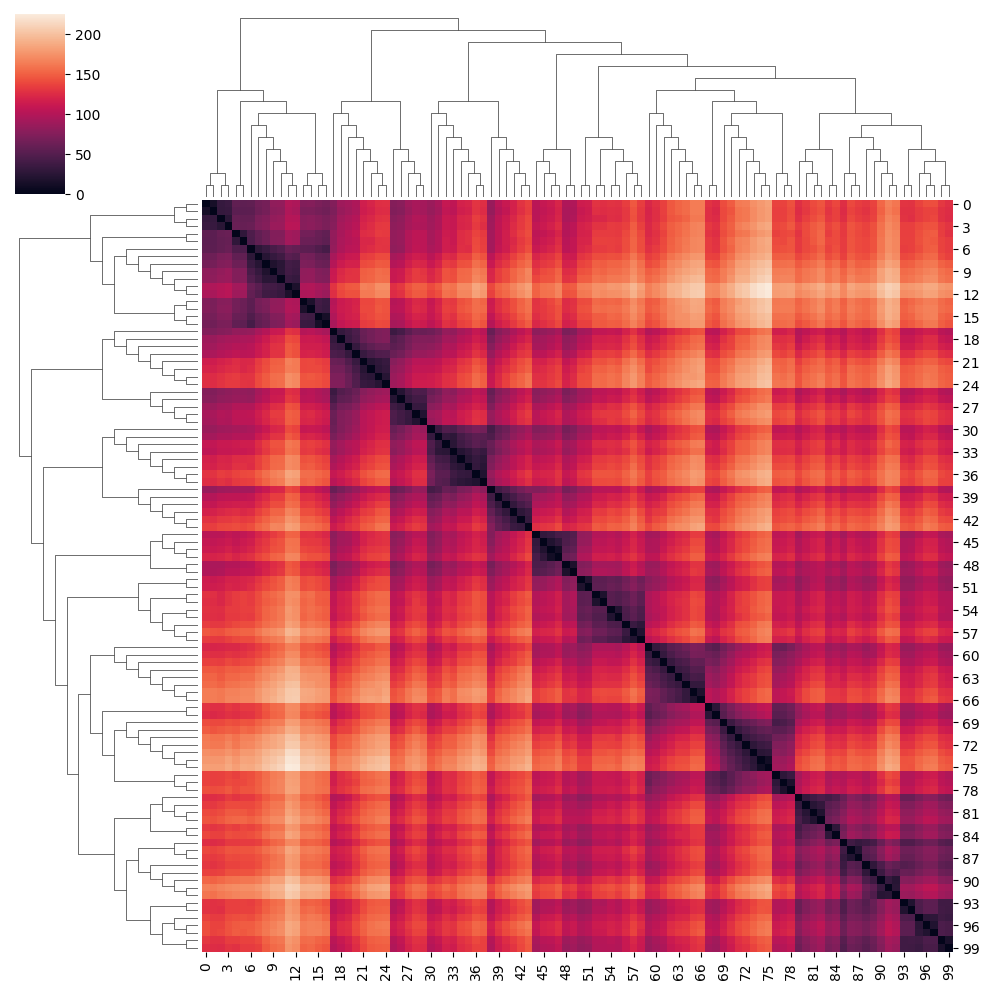

In [ ]:
# Get distance matrix from sequences

def seqs_to_dist(seqs):
    n = len(seqs)
    dist = np.zeros((n, n))
    leaves = tree.get_leaves()

    # Use Hamming, since pyvolve doesn't simulate indels anyway
    for i, leaf_i in enumerate(leaves):
        seq_i = seqs[leaf_i.name]
        for j, leaf_j in enumerate(leaves):
            seq_j = seqs[leaf_j.name]
            dist[i, j] = sum(a != b for a, b in zip(seq_i, seq_j))
    
    return dist

dist = seqs_to_dist(seqs)

sns.clustermap(dist, row_linkage=linkage, col_linkage=linkage)